

# 6.1

6.1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
import numpy as np

In [ ]:
def getNumNonRedundantPoints(x_train, y_train):
  non_important_num = 0
  for i in range(len(x_train)):
    x_train_removed = np.delete(x_train, i, axis=0)
    y_train_removed = np.delete(y_train, i)
    knn_removed = KNeighborsClassifier(n_neighbors=1)
    knn_removed.fit(x_train_removed, y_train_removed)
    if (knn_removed.predict([x_train[i]]) == y_train[i]):
      non_important_num += 1
  return len(x_train) - non_important_num

def getAvgNonRedundantPoints(n, d, classification_num):
  NUM_REPEATS = 100
  nonRedundantNums = np.array([])
  for i in range(NUM_REPEATS):
    X = np.random.rand(n, d)
    y = np.random.randint(0, classification_num, size=n)
    nonRedundantNums = np.append(nonRedundantNums, getNumNonRedundantPoints(X, y))
  return np.mean(nonRedundantNums)

def printRedundantPoints(n, d):
  print(f"d={d}, n={n}: ratio important points (n_important_points / n) = {n / getAvgNonRedundantPoints(n, d, 2)}")


printRedundantPoints(4, 2)
printRedundantPoints(16, 4)
printRedundantPoints(256, 8)

d=2, n=4: ratio important points (n_important_points / n) = 2.1978021978021975
d=4, n=16: ratio important points (n_important_points / n) = 1.9631901840490797
d=8, n=256: ratio important points (n_important_points / n) = 1.996257018091079


Binary classification:

d=2, n=4: ratio important points (n / n_important_points) = 1.9607843137254901

d=4, n=16: ratio important points (n / n_important_points) = 1.9512195121951221

d=8, n=256: ratio important points (n / n_important_points) = 1.9891219891219893

The ratio of important points to total number of points approaches 0.5.  This means that half of the number of points are redundant for the k-nearest-neighbors classifier.  This in turn means that each important point can memorize the labels for 2 total points, or in other words, that they hold 2 prediction bits.

Multi-class classification:

4-class

d=2, n=4: ratio important points (n / n_important_points) = 1.4084507042253522

d=4, n=16: ratio important points (n / n_important_points) = 1.335559265442404

d=8, n=256: ratio important points (n / n_important_points) = 1.3340976601177759

8-class

d=2, n=4: ratio important points (n / n_important_points) = 1.0989010989010988

d=4, n=16: ratio important points (n / n_important_points) = 1.1577424023154848

d=8, n=256: ratio important points (n / n_important_points) = 1.1402102262604668

# 6.2

6.2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import _tree
import seaborn as sns
import matplotlib.pyplot as plt

Breast Cancer
Iris
Random


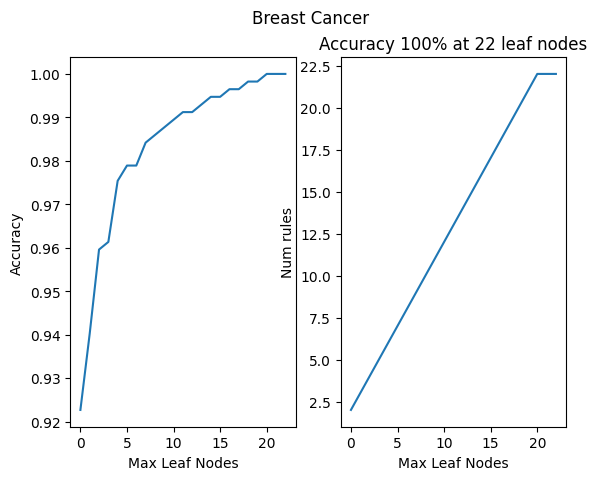

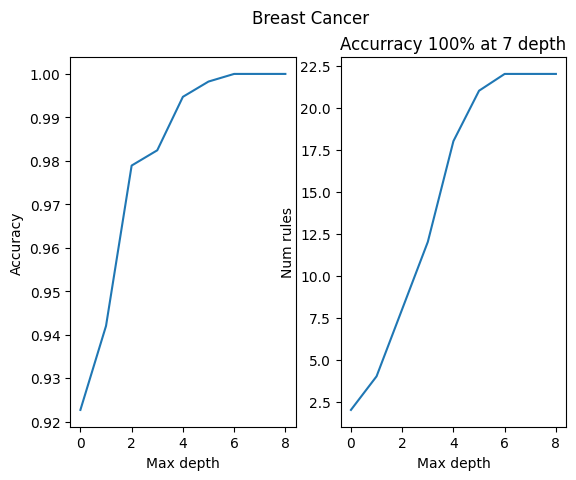

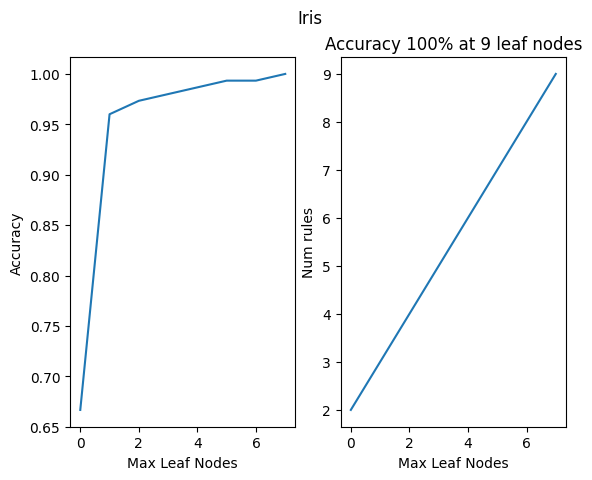

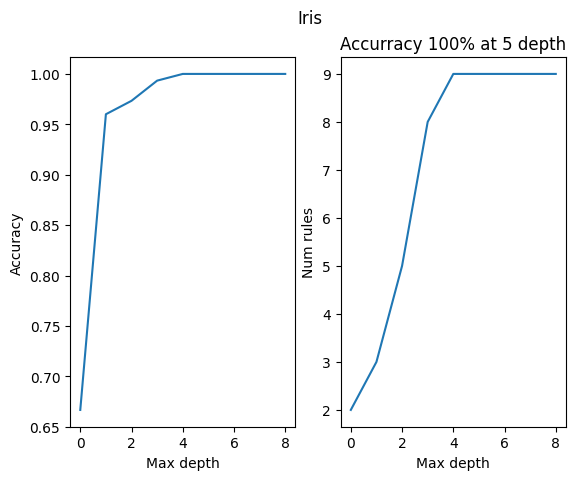

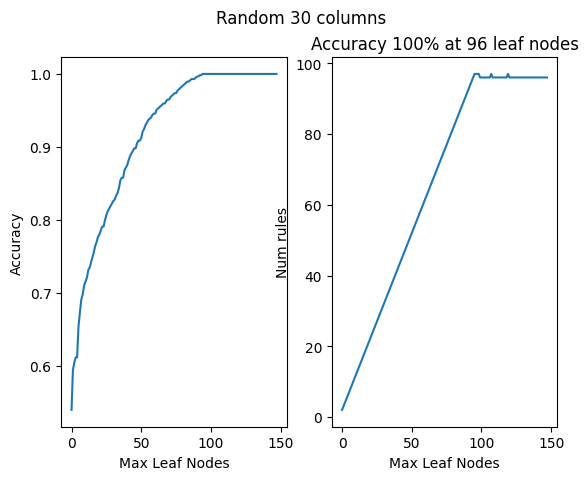

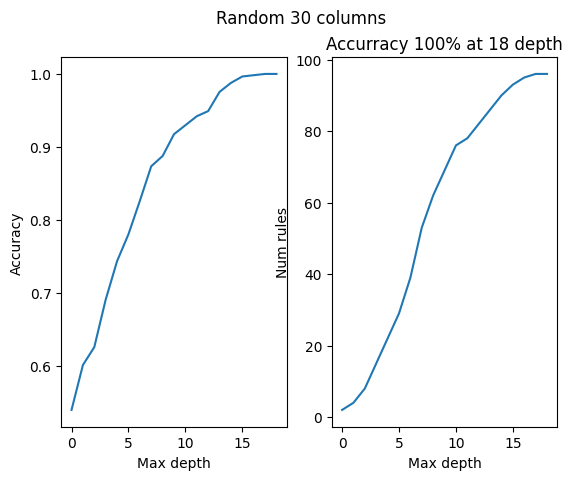

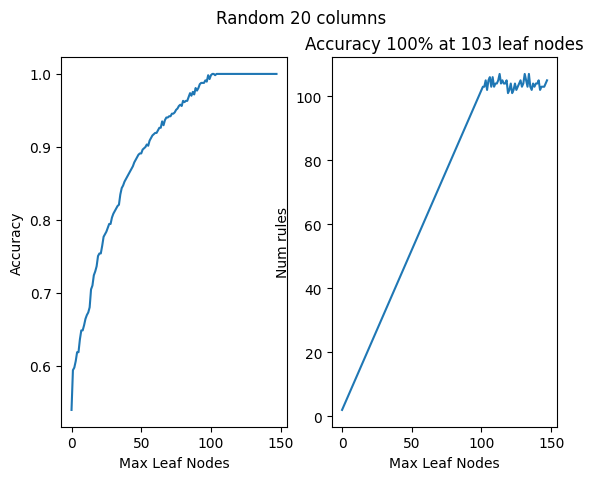

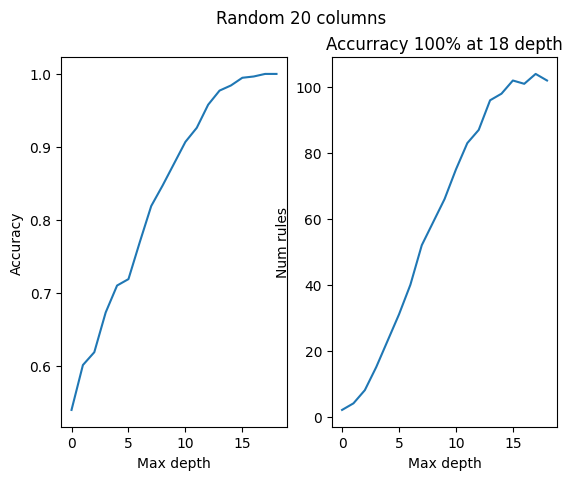

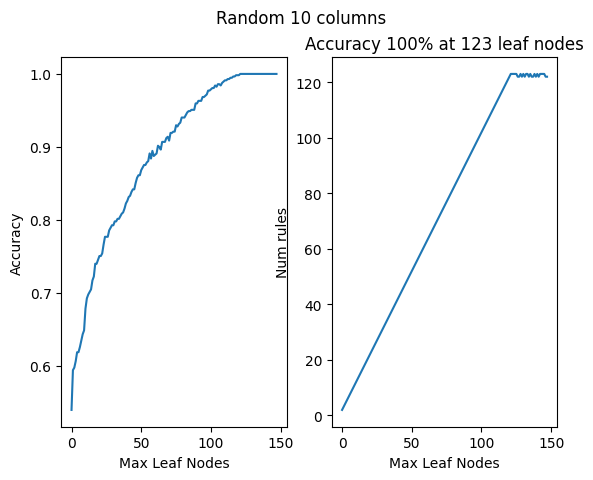

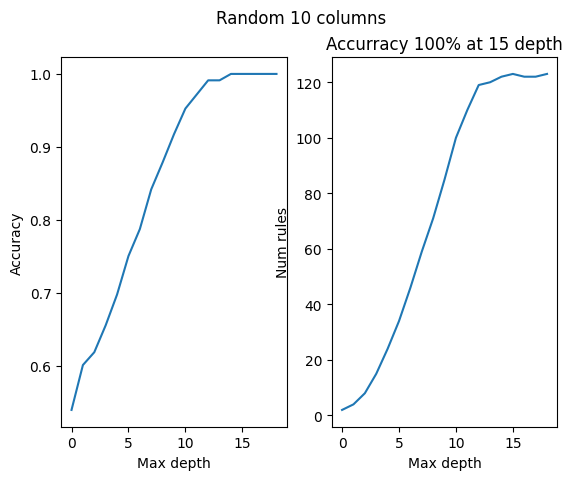

In [ ]:
#---------Code from https://mljar.com/blog/extract-rules-decision-tree/---------
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules
#-------------------------------------------------------------------------------

def plotDecisionTreeClassifier(x, y, feature_names, target_names, testLeafNodes, rangeEnd, title):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  accuracies = []
  numRules = []
  found100PercentAccuracy = False
  if (testLeafNodes):
      for i in range(2, rangeEnd):
        clf = DecisionTreeClassifier(max_leaf_nodes=i)
        clf.fit(x, y)
        rules = get_rules(clf, feature_names, target_names)
        numRules.append(len(rules))
        acc = accuracy_score(clf.predict(x), y)
        if (acc == 1.0 and not found100PercentAccuracy):
          found100PercentAccuracy = True
          plt.title(f"Accuracy 100% at {i} leaf nodes")
        accuracies.append(acc)
        ax1.set_xlabel("Max Leaf Nodes")
        ax2.set_xlabel("Max Leaf Nodes")
  else:
      for i in range(1, rangeEnd):
        clf = DecisionTreeClassifier(max_depth=i)
        clf.fit(x, y)
        rules = get_rules(clf, feature_names, target_names)
        numRules.append(len(rules))
        acc = accuracy_score(clf.predict(x), y)
        if (acc == 1.0 and not found100PercentAccuracy):
          found100PercentAccuracy = True
          plt.title(f"Accurracy 100% at {i} depth")
        accuracies.append(acc)
        ax1.set_xlabel("Max depth")
        ax2.set_xlabel("Max depth")
  fig.suptitle(title)
  ax1.plot(accuracies)
  ax2.plot(numRules)
  ax1.set_ylabel("Accuracy")
  ax2.set_ylabel("Num rules")
  plt.savefig(f"{title}_{'leaf nodes' if testLeafNodes else 'depth'}.png")
  # return rules

data = load_breast_cancer()
X, y = data.data, data.target
print("Breast Cancer")
plotDecisionTreeClassifier(X, y, data.feature_names, data.target_names, True, 25, "Breast Cancer")
plotDecisionTreeClassifier(X, y, data.feature_names, data.target_names, False, 10, "Breast Cancer")


data2 = load_iris()
X, y = data2.data, data2.target
print("Iris")
plotDecisionTreeClassifier(X, y, data2.feature_names, data2.target_names, True, 10, "Iris")
plotDecisionTreeClassifier(X, y, data2.feature_names, data2.target_names, False, 10, "Iris")

X = np.random.rand(569, 30)
y = np.random.randint(0, 2, size=569)
features = []
for i in range(30):
  features.append(str(i))
print("Random")
plotDecisionTreeClassifier(X, y, features, ["0", "1"], True, 150, "Random 30 columns")
plotDecisionTreeClassifier(X, y, features, ["0", "1"], False, 20, "Random 30 columns")
plotDecisionTreeClassifier(X[:, :20], y, features, ["0", "1"], True, 150, "Random 20 columns")
plotDecisionTreeClassifier(X[:, :20], y, features, ["0", "1"], False, 20, "Random 20 columns")
plotDecisionTreeClassifier(X[:, :10], y, features, ["0", "1"], True, 150, "Random 10 columns")
plotDecisionTreeClassifier(X[:, :10], y, features, ["0", "1"], False, 20, "Random 10 columns")


Strategies for limiting if-else statements:
- Limit max depth
- Limit max number of leafnodes

# 6.3

In [ ]:
import string
import random
import zlib

In [ ]:
random_string = str(''.join(random.choices(string.ascii_letters +
                             string.digits, k=1000)))
compressed = zlib.compress(random_string.encode('utf-8'))

print(compressed)
print(f"Compression ratio: {len(random_string) / len(compressed)}")

b'x\x9c\r\x93G\x92\x830\x00\x04\xbfD\x0eG,2\x16\xc1&\xdf\xc89\x1b\x90x\xfd\xee\xb9/]\xd53di\x99Tr\xebt\\p\xde\xcfM4\x028\xc6f\xde\x0cr\xa7\xb1\xe8\xbf\x80\xea\xa1\x01\xbc\x8b\xdae\xe5\rH\xd1\x9e\x84\xca\xe0\x15+$9e-\xfa\xa8K[\xab\x96\xde\xb5f\x90\\\x83lM\\\xbf\xb6A\x97\xbb\xc0$nS\xbb^\x1c\xe7rD\xa6\xf3\x01\xc5\xb1\x08\xd2(\xb1u\x96rp\x8b\xea\x9do\xe9\x02|e=G\xc7\xc8O\xda\xc2\x90e{\x83\xf5\x18\x06[h\x08\xb7v\x94I-\x08\xca\x13\x87\xb6\xac\xc4Dts\xb7O9\xff\x04\xe3#\xcd\xba{\xd7or\xb2\r\xf6\xa0\x1e\x9aXa\x9eJavHL/OWw\xcd\xbf\x96\xef\xb6\x1d\x18\x02\xce\xb1|\x7fkB\x01uy\x1d\xecS\x97\xedy?\xe0U\xe5%\x19\xe5]\x1b\xe4\xba!\xb4\xac\xd7\xa9\x9b\x99|(%a\xf0\rU\xc6\x14\x87\x0eE\x00?lP\x06\x05u4\xfb\x8e\xbey\xda[\xa6\x9aN\x90\x90\xbe\xefs\x813BLE\x07[\xbd"\xdb8\x7f\x1f\xc2\xe3\xd0\x0b\x86\xf8\xd0\xc8T\xf6\x84\x97\x07\x88hz\xf92\xd8^\xdbf\x05\x98\x8b:\x81\xff|~\x95\xd0\xc5\xf4m\xa6\xcc\xa8\x1a\xc97\xf8\xb9\x92h\xc3\xabe\x9d\x1c2\xf4\xde\xcf\x19\x86\xe9\xa1\xff\xb6\xdb\xedA\x96\x0eOz7\xd6\xea%\xf8!2\

The expected compression ratio is 266/265 = 1.004
This is because we expect G = c / (c-1).  For the string, the possible classifications are all asci letters (256) and all digits (10).  So c, or number of classes, = 256 + 10 = 266.


# 9.1

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
# Referenced from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

class Net_Reduced(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

net2 = Net_Reduced()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Net1')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.829
[1,  6000] loss: 1.641
[1,  8000] loss: 1.560
[1, 10000] loss: 1.489
[1, 12000] loss: 1.406
[2,  2000] loss: 1.344
[2,  4000] loss: 1.331
[2,  6000] loss: 1.292
[2,  8000] loss: 1.270
[2, 10000] loss: 1.254
[2, 12000] loss: 1.239
[3,  2000] loss: 1.168
[3,  4000] loss: 1.171
[3,  6000] loss: 1.180
[3,  8000] loss: 1.159
[3, 10000] loss: 1.143
[3, 12000] loss: 1.149
[4,  2000] loss: 1.047
[4,  4000] loss: 1.073
[4,  6000] loss: 1.089
[4,  8000] loss: 1.088
[4, 10000] loss: 1.081
[4, 12000] loss: 1.069
Finished Training Net1


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net1: {100 * correct // total} %')

Accuracy of Net1: 60 %


In [19]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training Net Reduced')

[1,  2000] loss: 2.000
[1,  4000] loss: 1.648
[1,  6000] loss: 1.537
[1,  8000] loss: 1.455
[1, 10000] loss: 1.406
[1, 12000] loss: 1.389
[2,  2000] loss: 1.336
[2,  4000] loss: 1.308
[2,  6000] loss: 1.308
[2,  8000] loss: 1.331
[2, 10000] loss: 1.259
[2, 12000] loss: 1.302
[3,  2000] loss: 1.249
[3,  4000] loss: 1.244
[3,  6000] loss: 1.234
[3,  8000] loss: 1.237
[3, 10000] loss: 1.249
[3, 12000] loss: 1.234
[4,  2000] loss: 1.209
[4,  4000] loss: 1.209
[4,  6000] loss: 1.192
[4,  8000] loss: 1.218
[4, 10000] loss: 1.221
[4, 12000] loss: 1.209
Finished Training Net Reduced


In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Reduced Net: {100 * correct // total} %')

Accuracy of Reduced Net: 57 %
